In [1]:
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()
# client = Client(cluster)

In [2]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=1,processes=1,memory="47GB")
client = Client(cluster)
cluster.scale(cores=3)

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.162:41143,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
print(client)

<Client: 'tcp://10.0.128.162:41143' processes=0 threads=0, memory=0 B>


In [5]:
cd /g/data/fu5/deg581/OSSE_analysis/notebooks/

/g/data1a/fu5/deg581/OSSE_analysis/notebooks


In [6]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [7]:
### new loads
import numpy.matlib
from xgcm import Grid
import matplotlib.ticker as mticker


### Load functions

In [8]:
### Other local functions

def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

### function to load overlapping OSSE data
def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    # err=err2**(1/2)
    mse = indexMeanMetric(err2,etaRange,xiRange) #mean square error MSE
    output = mse**(1/2)
    return mse,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")


def spatialMap_addGSSubplot(toPlotData, gs, nrow,ncol, labelText, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(150,160))
    gl.ylocator = mticker.FixedLocator(np.arange(-45,45))

    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=12, fontweight='bold', va='top')
    ax.set_title('')
    return ax

In [9]:
### Functions for calculating metrics

def loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates):
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    return sshForecast, sshAnalysis, sstForecast, sstAnalysis

def loadTruthdata(hisTruthFilePath,prefixTruth,dates):
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()
    return sshTruth, sstTruth

def compileOSSETimeMetricSSH(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
            temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
    return ssh_metricForecast,ssh_metricAnalysis

def compileOSSETimeMetricSST(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricForecast = xr.merge([sst_metricForecast, temp])
            temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
    return sst_metricForecast,sst_metricAnalysis

def compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshTruth,sstTruth = loadTruthdata(hisTruthFilePath,prefixTruth,dates)
        if dates == datelist[0]:
            ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
            temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = xr.merge([sst_metricTruth, temp])
    return ssh_metricTruth, sst_metricTruth

In [10]:
### Functions for loading and processing ROMS data nicely... ROMS FUNCTIONS

from xgcm import Grid

def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False)
    return gridOut

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho'],
                                    method='linear').squeeze()
    return output

In [11]:

def loadOSSEFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadOverlappedNetcdfFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadNetcdfFileListAverages(hisFilePath,prefix,filelist):

    outName = xr.open_mfdataset(filelist, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def generateFileList(hisFilePath,prefix,datelist):
    filelist=[hisFilePath+prefix+'0'+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=hisFilePath+prefix+'0'+str(dates)+'.nc'
        filelist.append(filenameToAppend)

#         print(filelist)
    return filelist

# downsample data to daily.
def calc_dailyDownsample(ds):
    ds_withtime = ds.drop([ var for var in ds.variables if not 'ocean_time' in ds[var].dims ])
    ds_timeless = ds.drop([ var for var in ds.variables if     'ocean_time' in ds[var].dims ])
    ds_workaround = xr.merge([ds_timeless, ds_withtime.resample(ocean_time='5D').mean('ocean_time')])
    return ds_workaround

# calculate EKE metrics
def calc_timeMeanEKE(input):
    u_eastward_top = input.u_eastward.isel(s_rho=-1)
    v_northward_top = input.v_northward.isel(s_rho=-1)

    u_bar = u_eastward_top.mean("ocean_time")
    v_bar = v_northward_top.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward_top - u_bar
    v_prime = v_northward_top - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)

    eketimemean = (eke*input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return eketimemean

def calc_MKEandEKElevel(input,level):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.isel(s_rho=level).mean("ocean_time")
    v_bar = v_northward.isel(s_rho=level).mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward.isel(s_rho=level) - u_bar
    v_prime = v_northward.isel(s_rho=level) - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def calc_MKEandEKEall(input):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.mean("ocean_time")
    v_bar = v_northward.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward - u_bar
    v_prime = v_northward - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho0'],
                                    method='linear').squeeze()
    return output

def calc_areaAverageROMS(input,grid):
    output = (input*grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return output

def calc_areaMedianROMS(input,grid):
    output = input*(grid.dA/grid.dA.sum(dim=['eta_rho','xi_rho'],skipna=True))
    output = np.median(output.values.flatten())
    return output

def process_trimVarsROMS(input,varsKeep):
    output_backup = input
    output = input[varsKeep]
    return output,output_backup

def calc_volTrans(input,etaLocation,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw<=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked.isel(eta_rho=transectEta)*input.dz.isel(eta_rho=transectEta)*input.dx.isel(eta_rho=transectEta)).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_volTransSlice(input,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw<=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked*input.dz*input.dx).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_volTransSliceNorth(input,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw>=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked*input.dz*input.dx).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_depthAverageROMS(input,grid,etaTransect):
    dz = grid.dz.mean(dim='ocean_time').isel(eta_rho=etaTransect)
    dx = grid.dx.isel(eta_rho=etaTransect)
    output = ((input*dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True))/(dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True)
    return output

def calc_depthAverageROMS2(input,dx,dz0,etaTransect):
    input = input.isel(eta_rho=etaTransect)
    dz = dz0.isel(eta_rho=etaTransect)
    dx = dx.isel(eta_rho=etaTransect)
    output = ((input*dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True))/(dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True)
    return output

In [12]:
hisTruthFilePath='/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/' # Truth file settings

hisOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
modOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
obsOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'

hisOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
modOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
obsOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'

hisOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
modOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
obsOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'

hisOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
modOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
obsOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixAverage='roms_avg_outer1_'
prefixTruth='outer_his_'
prefixTruthAverage='outer_avg_'

prefixObs='obs_0'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

In [13]:
timeRange = [8005, 8401]
datelist = np.array(range(timeRange[0],timeRange[1],4))

# time_range_to_load_S = slice('2012-01-01','2012-06-01')
# time_range_to_load_N = slice('2012-06-01','2012-11-01')

time_range_to_load_S = slice('2012-04-20','2012-04-21')
time_range_to_load_N = slice('2012-03-06','2012-03-07')
time_range_to_load_eddyN = slice('2012-06-29','2012-07-09')
time_range_to_load_eddy2 = slice('2012-07-29','2012-08-08')
time_range_to_load_eddy3 = slice('2012-03-11','2012-03-16')


range_S = (str(time_range_to_load_S.start)+' - '+str(time_range_to_load_S.stop))
range_N = (str(time_range_to_load_N.start)+' - '+str(time_range_to_load_N.stop))
range_eddyN = (str(time_range_to_load_eddyN.start)+' - '+str(time_range_to_load_eddyN.stop))
range_eddy2 = (str(time_range_to_load_eddy2.start)+' - '+str(time_range_to_load_eddy2.stop))
range_eddy3 = (str(time_range_to_load_eddy3.start)+' - '+str(time_range_to_load_eddy3.stop))

In [14]:
# Load zeta data
VarToKeep = ['u_eastward','v_northward','z_rho0','temp','zeta','salt']#,'dA','dx','dy','dz']

outputPath = '/g/data/fu5/deg581/OSSE_analysis/data/proc/'
outputPrefix = 'output_'
expNames=['truth','OSSE_SSHSST','OSSE_SSHSST_XBT','OSSE_SSHSST_XBT_N','OSSE_SSHSST_XBT_S']
outputSuffix = '_'+str(timeRange[0])+'_'+str(timeRange[1])+'.nc'
filelistTruth = outputPath+outputPrefix+expNames[0]+outputSuffix
filelist_SSHSST=outputPath+outputPrefix+expNames[1]+outputSuffix
filelist_SSHSST_XBT=outputPath+outputPrefix+expNames[2]+outputSuffix
filelist_SSHSST_XBT_N=outputPath+outputPrefix+expNames[3]+outputSuffix
filelist_SSHSST_XBT_S=outputPath+outputPrefix+expNames[4]+outputSuffix

truth = xr.open_dataset(filelistTruth)
truth,truth_bu = process_trimVarsROMS(truth,VarToKeep)
truth = truth.drop('z_rho')
truth["dz0"] = truth_bu.dz.mean(dim='ocean_time')
truth["dx"] = truth_bu.dx
truth["z_rho0"] = truth.z_rho0.fillna(0)

truth_S = truth.sel(ocean_time=time_range_to_load_S)
truth_N = truth.sel(ocean_time=time_range_to_load_N)
truth_S.load(), print('done, loaded ~'+str(truth_S.nbytes/1024/1024/1024)+'G')
truth_N.load(), print('done, loaded ~'+str(truth_N.nbytes/1024/1024/1024)+'G')


VarToKeep = ['u_eastward','v_northward','z_rho0','temp','salt','zeta']#,'dA','dx','dy','dz']

OSSE_SSHSST= xr.open_dataset(filelist_SSHSST)
OSSE_SSHSST_XBT= xr.open_dataset(filelist_SSHSST_XBT)
OSSE_SSHSST_XBT_N= xr.open_dataset(filelist_SSHSST_XBT_N)
OSSE_SSHSST_XBT_S= xr.open_dataset(filelist_SSHSST_XBT_S)

#load grid file
grid = makeROMSGridObject(OSSE_SSHSST)

OSSE_SSHSST,OSSE_SSHSST_bu = process_trimVarsROMS(OSSE_SSHSST,VarToKeep)
OSSE_SSHSST_XBT_S,OSSE_SSHSST_XBT_S_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_S,VarToKeep)
OSSE_SSHSST_XBT_N,OSSE_SSHSST_XBT_N_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_N,VarToKeep)
OSSE_SSHSST_XBT,OSSE_SSHSST_XBT_bu = process_trimVarsROMS(OSSE_SSHSST_XBT,VarToKeep)

OSSE_SSHSST = OSSE_SSHSST.drop('z_rho')
OSSE_SSHSST_XBT = OSSE_SSHSST_XBT.drop('z_rho')
OSSE_SSHSST_XBT_N = OSSE_SSHSST_XBT_N.drop('z_rho')
OSSE_SSHSST_XBT_S = OSSE_SSHSST_XBT_S.drop('z_rho')

OSSE_SSHSST["z_rho0"] = OSSE_SSHSST.z_rho0.fillna(0)
OSSE_SSHSST_XBT["z_rho0"] = OSSE_SSHSST_XBT.z_rho0.fillna(0)
OSSE_SSHSST_XBT_N["z_rho0"] = OSSE_SSHSST_XBT_N.z_rho0.fillna(0)
OSSE_SSHSST_XBT_S["z_rho0"] = OSSE_SSHSST_XBT_S.z_rho0.fillna(0)

OSSE_SSHSST["dx"] = OSSE_SSHSST_bu.dx
OSSE_SSHSST_XBT["dx"] = OSSE_SSHSST_XBT_bu.dx
OSSE_SSHSST_XBT_N["dx"] = OSSE_SSHSST_XBT_N_bu.dx
OSSE_SSHSST_XBT_S["dx"] = OSSE_SSHSST_XBT_S_bu.dx

OSSE_SSHSST["dz0"] = OSSE_SSHSST_bu.dz.mean(dim='ocean_time')
OSSE_SSHSST_XBT["dz0"] = OSSE_SSHSST_XBT_bu.dz.mean(dim='ocean_time')
OSSE_SSHSST_XBT_N["dz0"] = OSSE_SSHSST_XBT_N_bu.dz.mean(dim='ocean_time')
OSSE_SSHSST_XBT_S["dz0"] = OSSE_SSHSST_XBT_S_bu.dz.mean(dim='ocean_time')


SSHSST_S = OSSE_SSHSST.sel(ocean_time=time_range_to_load_S)
SSHSST_XBT_S1 = OSSE_SSHSST_XBT.sel(ocean_time=time_range_to_load_S)
SSHSST_XBT_N_S = OSSE_SSHSST_XBT_N.sel(ocean_time=time_range_to_load_S)
SSHSST_XBT_S_S = OSSE_SSHSST_XBT_S.sel(ocean_time=time_range_to_load_S)

SSHSST_N = OSSE_SSHSST.sel(ocean_time=time_range_to_load_N)
SSHSST_XBT_N1 = OSSE_SSHSST_XBT.sel(ocean_time=time_range_to_load_N)
SSHSST_XBT_N_N = OSSE_SSHSST_XBT_N.sel(ocean_time=time_range_to_load_N)
SSHSST_XBT_S_N = OSSE_SSHSST_XBT_S.sel(ocean_time=time_range_to_load_N)

SSHSST_S.load(), print('done, loaded ~'+str(SSHSST_S.nbytes/1024/1024/1024)+'G')
SSHSST_N.load(), print('done, loaded ~'+str(SSHSST_N.nbytes/1024/1024/1024)+'G')

SSHSST_XBT_S1.load(), print('done, loaded ~'+str(SSHSST_XBT_S1.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_N1.load(), print('done, loaded ~'+str(SSHSST_XBT_N1.nbytes/1024/1024/1024)+'G')

SSHSST_XBT_N_S.load(), print('done, loaded ~'+str(SSHSST_XBT_N_S.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_N_N.load(), print('done, loaded ~'+str(SSHSST_XBT_N_N.nbytes/1024/1024/1024)+'G')

SSHSST_XBT_S_S.load(), print('done, loaded ~'+str(SSHSST_XBT_S_S.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_S_N.load(), print('done, loaded ~'+str(SSHSST_XBT_S_N.nbytes/1024/1024/1024)+'G')



truth_eddyN = truth.sel(ocean_time=time_range_to_load_eddyN)
truth_eddyN.load(), print('done, loaded ~'+str(truth_eddyN.nbytes/1024/1024/1024)+'G')
SSHSST_eddyN = OSSE_SSHSST.sel(ocean_time=time_range_to_load_eddyN)
SSHSST_XBT_eddyN = OSSE_SSHSST_XBT.sel(ocean_time=time_range_to_load_eddyN)
SSHSST_XBT_N_eddyN = OSSE_SSHSST_XBT_N.sel(ocean_time=time_range_to_load_eddyN)
SSHSST_XBT_S_eddyN = OSSE_SSHSST_XBT_S.sel(ocean_time=time_range_to_load_eddyN)
SSHSST_eddyN.load(), print('done, loaded ~'+str(SSHSST_eddyN.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_eddyN.load(), print('done, loaded ~'+str(SSHSST_XBT_eddyN.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_N_eddyN.load(), print('done, loaded ~'+str(SSHSST_XBT_N_eddyN.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_S_eddyN.load(), print('done, loaded ~'+str(SSHSST_XBT_S_eddyN.nbytes/1024/1024/1024)+'G')




truth_eddy2 = truth.sel(ocean_time=time_range_to_load_eddy2)
truth_eddy2.load(), print('done, loaded ~'+str(truth_eddy2.nbytes/1024/1024/1024)+'G')
SSHSST_eddy2 = OSSE_SSHSST.sel(ocean_time=time_range_to_load_eddy2)
SSHSST_XBT_eddy2 = OSSE_SSHSST_XBT.sel(ocean_time=time_range_to_load_eddy2)
SSHSST_XBT_N_eddy2 = OSSE_SSHSST_XBT_N.sel(ocean_time=time_range_to_load_eddy2)
SSHSST_XBT_S_eddy2 = OSSE_SSHSST_XBT_S.sel(ocean_time=time_range_to_load_eddy2)
SSHSST_eddy2.load(), print('done, loaded ~'+str(SSHSST_eddy2.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_eddy2.load(), print('done, loaded ~'+str(SSHSST_XBT_eddy2.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_N_eddy2.load(), print('done, loaded ~'+str(SSHSST_XBT_N_eddy2.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_S_eddy2.load(), print('done, loaded ~'+str(SSHSST_XBT_S_eddy2.nbytes/1024/1024/1024)+'G')


truth_eddy3 = truth.sel(ocean_time=time_range_to_load_eddy3)
truth_eddy3.load(), print('done, loaded ~'+str(truth_eddy3.nbytes/1024/1024/1024)+'G')
SSHSST_eddy3 = OSSE_SSHSST.sel(ocean_time=time_range_to_load_eddy3)
SSHSST_XBT_eddy3 = OSSE_SSHSST_XBT.sel(ocean_time=time_range_to_load_eddy3)
SSHSST_XBT_N_eddy3 = OSSE_SSHSST_XBT_N.sel(ocean_time=time_range_to_load_eddy3)
SSHSST_XBT_S_eddy3 = OSSE_SSHSST_XBT_S.sel(ocean_time=time_range_to_load_eddy3)
SSHSST_eddy3.load(), print('done, loaded ~'+str(SSHSST_eddy3.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_eddy3.load(), print('done, loaded ~'+str(SSHSST_XBT_eddy3.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_N_eddy3.load(), print('done, loaded ~'+str(SSHSST_XBT_N_eddy3.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_S_eddy3.load(), print('done, loaded ~'+str(SSHSST_XBT_S_eddy3.nbytes/1024/1024/1024)+'G')

done, loaded ~0.10856901854276657G
done, loaded ~0.10856901854276657G
done, loaded ~0.11820530146360397G
done, loaded ~0.11820530146360397G
done, loaded ~0.11820530146360397G
done, loaded ~0.11820530146360397G
done, loaded ~0.11820530146360397G
done, loaded ~0.11820530146360397G
done, loaded ~0.11820530146360397G
done, loaded ~0.11820530146360397G
done, loaded ~0.24476183205842972G
done, loaded ~0.2736706808209419G
done, loaded ~0.2736706808209419G
done, loaded ~0.2736706808209419G
done, loaded ~0.2736706808209419G
done, loaded ~0.24476183205842972G
done, loaded ~0.2736706808209419G
done, loaded ~0.2736706808209419G
done, loaded ~0.2736706808209419G
done, loaded ~0.2736706808209419G
done, loaded ~0.17666542530059814G
done, loaded ~0.19593799114227295G
done, loaded ~0.19593799114227295G
done, loaded ~0.19593799114227295G
done, loaded ~0.19593799114227295G


(<xarray.Dataset>
 Dimensions:      (ocean_time: 2, s_rho: 30, eta_rho: 317, xi_rho: 272)
 Coordinates:
     z_rho0       (eta_rho, xi_rho, s_rho) float64 0.0 0.0 0.0 ... -4.485 -1.037
   * s_rho        (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
     lon_rho      (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
     lat_rho      (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
   * ocean_time   (ocean_time) datetime64[ns] 2012-03-11 2012-03-16
 Dimensions without coordinates: eta_rho, xi_rho
 Data variables:
     u_eastward   (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 0.0
     v_northward  (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 0.0
     temp         (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 25.1
     salt         (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 35.53
     zeta         (ocean_time, eta_rho, xi_rho) float64 nan nan ... 0.5409 0.5409
     dx           (eta_rho, xi_rho) floa

In [15]:
truth_S["temp250"] = horizontalSectionROMS(grid, truth_S.temp, np.array([-250]))
truth_S["v250"] = horizontalSectionROMS(grid, truth_S.v_northward, np.array([-250]))
truth_S["u250"] = horizontalSectionROMS(grid, truth_S.u_eastward, np.array([-250]))
print('done')
truth_N["temp250"] = horizontalSectionROMS(grid, truth_N.temp, np.array([-250]))
truth_N["v250"] = horizontalSectionROMS(grid, truth_N.v_northward, np.array([-250]))
truth_N["u250"] = horizontalSectionROMS(grid, truth_N.u_eastward, np.array([-250]))
print('done')
truth_eddyN["temp250"] = horizontalSectionROMS(grid, truth_eddyN.temp, np.array([-250]))
truth_eddyN["v250"] = horizontalSectionROMS(grid, truth_eddyN.v_northward, np.array([-250]))
truth_eddyN["u250"] = horizontalSectionROMS(grid, truth_eddyN.u_eastward, np.array([-250]))
print('done')
truth_eddy2["temp250"] = horizontalSectionROMS(grid, truth_eddy2.temp, np.array([-250]))
truth_eddy2["v250"] = horizontalSectionROMS(grid, truth_eddy2.v_northward, np.array([-250]))
truth_eddy2["u250"] = horizontalSectionROMS(grid, truth_eddy2.u_eastward, np.array([-250]))
print('done')
truth_eddy3["temp250"] = horizontalSectionROMS(grid, truth_eddy3.temp, np.array([-250]))
truth_eddy3["v250"] = horizontalSectionROMS(grid, truth_eddy3.v_northward, np.array([-250]))
truth_eddy3["u250"] = horizontalSectionROMS(grid, truth_eddy3.u_eastward, np.array([-250]))
print('done')
SSHSST_S["temp250"] = horizontalSectionROMS(grid, SSHSST_S.temp, np.array([-250]))
SSHSST_S["v250"] = horizontalSectionROMS(grid, SSHSST_S.v_northward, np.array([-250]))
SSHSST_S["u250"] = horizontalSectionROMS(grid, SSHSST_S.u_eastward, np.array([-250]))
print('done')
SSHSST_XBT_N_S["temp250"] = horizontalSectionROMS(grid, SSHSST_XBT_N_S.temp, np.array([-250]))
SSHSST_XBT_N_S["v250"] = horizontalSectionROMS(grid, SSHSST_XBT_N_S.v_northward, np.array([-250]))
SSHSST_XBT_N_S["u250"] = horizontalSectionROMS(grid, SSHSST_XBT_N_S.u_eastward, np.array([-250]))
print('done')
SSHSST_XBT_S_S["temp250"] = horizontalSectionROMS(grid, SSHSST_XBT_S_S.temp, np.array([-250]))
SSHSST_XBT_S_S["v250"] = horizontalSectionROMS(grid, SSHSST_XBT_S_S.v_northward, np.array([-250]))
SSHSST_XBT_S_S["u250"] = horizontalSectionROMS(grid, SSHSST_XBT_S_S.u_eastward, np.array([-250]))
print('done')
SSHSST_XBT_S1["temp250"] = horizontalSectionROMS(grid, SSHSST_XBT_S1.temp, np.array([-250]))
SSHSST_XBT_S1["v250"] = horizontalSectionROMS(grid, SSHSST_XBT_S1.v_northward, np.array([-250]))
SSHSST_XBT_S1["u250"] = horizontalSectionROMS(grid, SSHSST_XBT_S1.u_eastward, np.array([-250]))
print('done')
SSHSST_N["temp250"] = horizontalSectionROMS(grid, SSHSST_N.temp, np.array([-250]))
SSHSST_N["v250"] = horizontalSectionROMS(grid, SSHSST_N.v_northward, np.array([-250]))
SSHSST_N["u250"] = horizontalSectionROMS(grid, SSHSST_N.u_eastward, np.array([-250]))
print('done')
SSHSST_XBT_N_N["temp250"] = horizontalSectionROMS(grid, SSHSST_XBT_N_N.temp, np.array([-250]))
SSHSST_XBT_N_N["v250"] = horizontalSectionROMS(grid, SSHSST_XBT_N_N.v_northward, np.array([-250]))
SSHSST_XBT_N_N["u250"] = horizontalSectionROMS(grid, SSHSST_XBT_N_N.u_eastward, np.array([-250]))
print('done')
SSHSST_XBT_S_N["temp250"] = horizontalSectionROMS(grid, SSHSST_XBT_S_N.temp, np.array([-250]))
SSHSST_XBT_S_N["v250"] = horizontalSectionROMS(grid, SSHSST_XBT_S_N.v_northward, np.array([-250]))
SSHSST_XBT_S_N["u250"] = horizontalSectionROMS(grid, SSHSST_XBT_S_N.u_eastward, np.array([-250]))
print('done')
SSHSST_XBT_N1["temp250"] = horizontalSectionROMS(grid, SSHSST_XBT_N1.temp, np.array([-250]))
SSHSST_XBT_N1["v250"] = horizontalSectionROMS(grid, SSHSST_XBT_N1.v_northward, np.array([-250]))
SSHSST_XBT_N1["u250"] = horizontalSectionROMS(grid, SSHSST_XBT_N1.u_eastward, np.array([-250]))
print('done')

done
done
done
done
done
done
done
done
done
done
done
done
done


In [16]:


etaTransect=60
xx_60=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
zz_60=truth.z_rho0.isel(eta_rho=etaTransect).fillna(0).transpose()
zz_60.load(),print('done')
etaTransect=40
xx_40=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
zz_40=truth.z_rho0.isel(eta_rho=etaTransect).fillna(0).transpose()
zz_40.load(),print('done')
etaTransect=55
xx_55=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
zz_55=truth.z_rho0.isel(eta_rho=etaTransect).fillna(0).transpose()
zz_55.load(),print('done')
etaTransect=47
xx_47=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
zz_47=truth.z_rho0.isel(eta_rho=etaTransect).fillna(0).transpose()
zz_47.load(),print('done')
etaTransect=35
xx_35=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
zz_35=truth.z_rho0.isel(eta_rho=etaTransect).fillna(0).transpose()
zz_35.load(),print('done')



done
done
done
done
done


(<xarray.DataArray 'z_rho0' (s_rho: 30, xi_rho: 272)>
 array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -4.46077616e+03, -4.45754371e+03, -4.45754371e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -4.18987050e+03, -4.18683513e+03, -4.18683513e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -3.69285168e+03, -3.69019072e+03, -3.69019072e+03],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.05161441e+01, -1.05143882e+01, -1.05143882e+01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -5.70949498e+00, -5.70819800e+00, -5.70819800e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.63964233e+00, -1.63865581e+00, -1.63865581e+00]])
 Coordinates:
     z_rho0   (s_rho, xi_rho) float64 0.0 0.0 0.0 0.0 ... -1.64 -1.639 -1.639
   * s_rho    (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
     lon

Text(156.5, -36.45, 'XBT-S')

<Figure size 432x288 with 0 Axes>

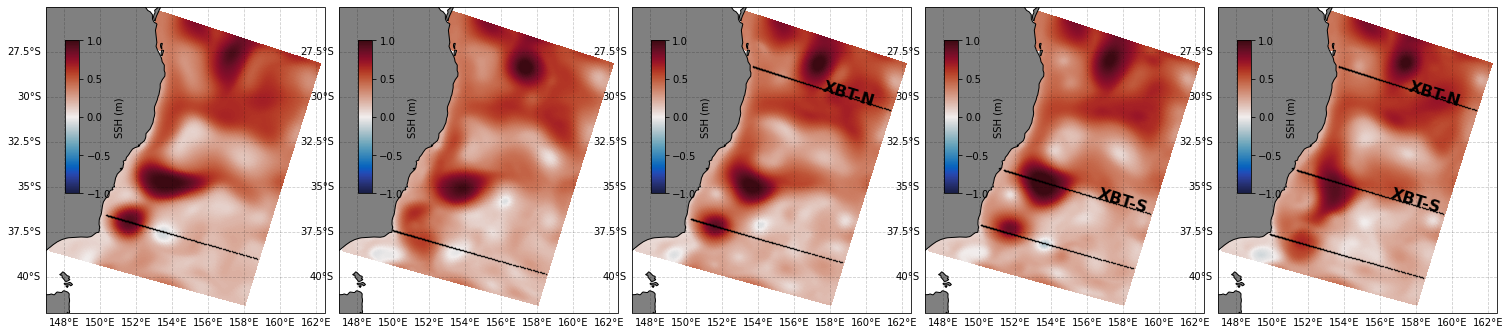

In [17]:
snap = truth



gs = gridspec.GridSpec(nrows=1,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[26,10])
ax = None


toPlotData=truth_eddy3.zeta.mean(dim='ocean_time')
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax = plt.gca()
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, cmap='cmo.balance',vmin=-1,vmax=1)       
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('SSH (m)')
ax.set_title('')  
ax.set(ylabel="Latitude", xlabel="Longitude")
transectEta=60
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)



toPlotData=SSHSST_eddy3.zeta.mean(dim='ocean_time')
ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
ax = plt.gca()
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, cmap='cmo.balance',vmin=-1,vmax=1)       
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('SSH (m)')
ax.set_title('')  
ax.set(ylabel="Latitude", xlabel="Longitude")
transectEta=40
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)




toPlotData=SSHSST_XBT_N_eddy3.zeta.mean(dim='ocean_time')
ax = fig.add_subplot(gs[0,2], projection=ccrs.PlateCarree())
ax = plt.gca()
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, cmap='cmo.balance',vmin=-1,vmax=1)       
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('SSH (m)')
ax.set_title('')  
ax.set(ylabel="Latitude", xlabel="Longitude")
transectEta=55
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)

transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
ax.annotate('XBT-N', xy=(157.5,-30.5),xycoords='data',fontweight='bold',rotation=-17,fontsize=16)


toPlotData=SSHSST_XBT_S_eddy3.zeta.mean(dim='ocean_time')
ax = fig.add_subplot(gs[0,3], projection=ccrs.PlateCarree())
ax = plt.gca()
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, cmap='cmo.balance',vmin=-1,vmax=1)       
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('SSH (m)')
ax.set_title('')  
ax.set(ylabel="Latitude", xlabel="Longitude")
transectEta=47
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)


transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
ax.annotate('XBT-S', xy=(156.5,-36.45),xycoords='data',fontweight='bold',rotation=-17,fontsize=16)



toPlotData=SSHSST_XBT_eddy3.zeta.mean(dim='ocean_time')
ax = fig.add_subplot(gs[0,4], projection=ccrs.PlateCarree())
ax = plt.gca()
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, cmap='cmo.balance',vmin=-1,vmax=1)       
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('SSH (m)')
ax.set_title('')  
ax.set(ylabel="Latitude", xlabel="Longitude")
transectEta=35
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)


transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
ax.annotate('XBT-N', xy=(157.5,-30.5),xycoords='data',fontweight='bold',rotation=-17,fontsize=16)
ax.annotate('XBT-S', xy=(156.5,-36.45),xycoords='data',fontweight='bold',rotation=-17,fontsize=16)



<Figure size 432x288 with 0 Axes>

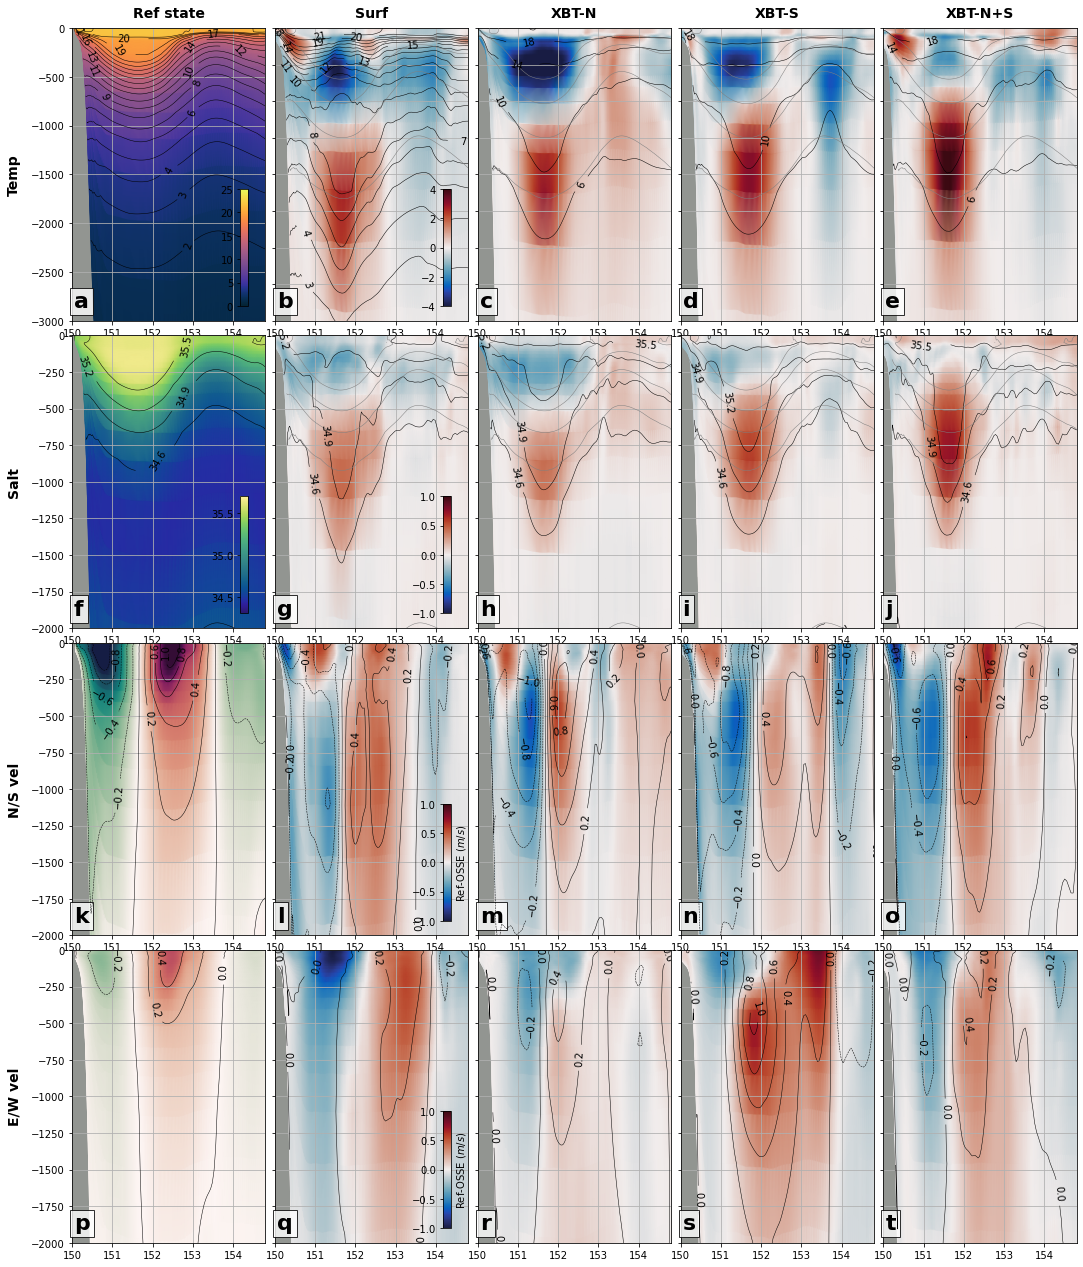

In [18]:

# toPlotData=truth_eddy3.zeta.mean(dim='ocean_time')


# gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
# plt.cla()
# plt.clf()
# fig = plt.figure(figsize=[12.3,8])
# ax = None

# ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
# ax = plt.gca()
# ax.set_extent([147, 162.5, -42, -25])
# feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
# im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, cmap='cmo.balance',vmin=-1,vmax=1)       
# gl = ax.gridlines(draw_labels=True,
#                     color='black', alpha=0.2, linestyle='--')

# gl.right_labels = False
# gl.top_labels = False
# cax = inset_axes(ax,
#                 width="5%",  # width = 10% of parent_bbox width
#                 height="50%",  # height : 50%
#                 loc='lower left',
#                 bbox_to_anchor=(.07,.39, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im, cax=cax) 
# cbar.set_label('SSH (m)')
# ax.set_title('')  
# ax.set(ylabel="Latitude", xlabel="Longitude")
# transectEta=60
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)

# toPlotData=truth_eddy3.temp250.mean(dim='ocean_time')
# ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
# pcol_params={"cmap":"cmo.thermal","vmin":15, "vmax":30, "zorder":1}#, "add_colorbar":"False"}
# cont_params={"colors":"black"}
# ax = plt.gca()
# ax.set_extent([147, 162.5, -42, -25])
# feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
# im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, cmap='cmo.thermal')       
# gl = ax.gridlines(draw_labels=True,
#                     color='black', alpha=0.2, linestyle='--')
# gl.right_labels = False
# gl.top_labels = False
# cax = inset_axes(ax,
#                 width="5%",  # width = 10% of parent_bbox width
#                 height="50%",  # height : 50%
#                 loc='lower left',
#                 bbox_to_anchor=(.07,.39, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im, cax=cax) 
# cbar.set_label('Temperature at 500m ($^\circ$C)')
# ax.set_title('')  
# ax.set(ylabel="Latitude", xlabel="Longitude")
# transectEta=60
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
# ax.annotate('XBT-N', xy=(157.5,-30.5),xycoords='data',fontweight='bold',rotation=-17,fontsize=16)
# ax.annotate('XBT-S', xy=(156.5,-36.45),xycoords='data',fontweight='bold',rotation=-17,fontsize=16)
# plt.show()

def addSubplot_VerticalTransect(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    # cax = inset_axes(ax,
    #              width="5%",  # width = 10% of parent_bbox width
    #              height="50%",  # height : 50%
    #              loc='lower left',
    #              bbox_to_anchor=(.05,.09, .8, .8),
    #              bbox_transform=ax.transAxes,
    #              borderpad=0,
    #              )
    ax.set_ylim([-2000,0])
    # cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.1, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
    ax.grid()
    return ax,im

def addSubplot_VerticalTransect_colorbar(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.87,.05, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    cax.yaxis.tick_left()
    # cax.set_ylabel('vel ($m/s$)')
    ax.set_ylim([-2000,0])
    ax.text(0.01, 0.1, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
    ax.grid()
    return ax,cax,im


gs = gridspec.GridSpec(nrows=5,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[18,28])
ax = None

#60,40,55,47,35

ax = addSubplot_VerticalTransect_colorbar(xx_60,zz_60, truth_eddy3.temp.isel(eta_rho=60).mean(dim='ocean_time') ,gs,0,0,'a',pcol_kwargs={'vmin':0,'vmax':25,'cmap':'cmo.thermal'})#, ax1[0].set_title('u (m/s)')
ax[0].text(-.3, .5, 'Temp',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax[0].transAxes)
co = ax[0].contour(xx_60,zz_60,truth_eddy3.temp.isel(eta_rho=60).mean(dim='ocean_time'),levels=np.arange(0,30,1),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_xlim([150,154.8])
ax[0].set_ylim([-3000,0])
ax[0].text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)

ax = addSubplot_VerticalTransect_colorbar(xx_40,zz_40, SSHSST_eddy3.temp.isel(eta_rho=40).mean(dim='ocean_time')-truth_eddy3.temp.isel(eta_rho=40).mean(dim='ocean_time') ,gs,0,1,'b',pcol_kwargs={'vmin':-4,'vmax':4,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
# ax = addSubplot_VerticalTransect(xx_60,zz_60, ((( SSHSST_eddy3.v_northward.isel(eta_rho=60)-truth_eddy3.v_northward.isel(eta_rho=60) )**2).mean(dim='ocean_time'))**(1/2) ,gs,0,1,'n',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_40,zz_40,SSHSST_eddy3.temp.isel(eta_rho=40).mean(dim='ocean_time'),levels=np.arange(0,30,1),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
co = ax[0].contour(xx_60,zz_60,truth_eddy3.temp.isel(eta_rho=60).mean(dim='ocean_time'),levels=np.arange(6,30,4),colors='grey',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([150,154.8])
ax[0].set_ylim([-2000,0])
ax[0].text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)

ax = addSubplot_VerticalTransect(xx_55,zz_55, SSHSST_XBT_N_eddy3.temp.isel(eta_rho=55).mean(dim='ocean_time')-truth_eddy3.temp.isel(eta_rho=55).mean(dim='ocean_time') ,gs,0,2,'c',pcol_kwargs={'vmin':-4,'vmax':4,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_55,zz_55,SSHSST_XBT_N_eddy3.temp.isel(eta_rho=55).mean(dim='ocean_time'),levels=np.arange(6,30,4),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
co = ax[0].contour(xx_60,zz_60,truth_eddy3.temp.isel(eta_rho=60).mean(dim='ocean_time'),levels=np.arange(6,30,4),colors='grey',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([150,154.8])
ax[0].set_ylim([-2000,0])
ax[0].text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)

ax = addSubplot_VerticalTransect(xx_47,zz_47, SSHSST_XBT_S_eddy3.temp.isel(eta_rho=47).mean(dim='ocean_time')-truth_eddy3.temp.isel(eta_rho=47).mean(dim='ocean_time') ,gs,0,3,'d',pcol_kwargs={'vmin':-4,'vmax':4,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_47,zz_47,SSHSST_XBT_S_eddy3.temp.isel(eta_rho=47).mean(dim='ocean_time'),levels=np.arange(6,30,4),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
co = ax[0].contour(xx_60,zz_60,truth_eddy3.temp.isel(eta_rho=60).mean(dim='ocean_time'),levels=np.arange(6,30,4),colors='grey',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([150,154.8])
ax[0].set_ylim([-2000,0])
ax[0].text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)

ax = addSubplot_VerticalTransect(xx_35,zz_35, SSHSST_XBT_eddy3.temp.isel(eta_rho=35).mean(dim='ocean_time')-truth_eddy3.temp.isel(eta_rho=35).mean(dim='ocean_time') ,gs,0,4,'e',pcol_kwargs={'vmin':-4,'vmax':4,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_35,zz_35,SSHSST_XBT_eddy3.temp.isel(eta_rho=35).mean(dim='ocean_time'),levels=np.arange(6,30,4),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
co = ax[0].contour(xx_60,zz_60,truth_eddy3.temp.isel(eta_rho=60).mean(dim='ocean_time'),levels=np.arange(6,30,4),colors='grey',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([150,154.8])
ax[0].set_ylim([-2000,0])
ax[0].text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)

###

#60,40,55,47,35


ax = addSubplot_VerticalTransect_colorbar(xx_60,zz_60, truth_eddy3.salt.isel(eta_rho=60).mean(dim='ocean_time') ,gs,1,0,'f',pcol_kwargs={'vmin':34.3,'vmax':35.7,'cmap':'cmo.haline'})#, ax1[0].set_title('u (m/s)')
ax[0].text(-.3, .5, 'Salt',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax[0].transAxes)
co = ax[0].contour(xx_60,zz_60,truth_eddy3.salt.isel(eta_rho=60).mean(dim='ocean_time'),levels=np.arange(34.3,35.9,.3),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_xlim([150,154.8])
ax[0].set_ylim([-2000,0])

ax = addSubplot_VerticalTransect_colorbar(xx_40,zz_40, SSHSST_eddy3.salt.isel(eta_rho=40).mean(dim='ocean_time')-truth_eddy3.salt.isel(eta_rho=40).mean(dim='ocean_time') ,gs,1,1,'g',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
# ax = addSubplot_VerticalTransect(xx_60,zz_60, ((( SSHSST_eddy3.v_northward.isel(eta_rho=60)-truth_eddy3.v_northward.isel(eta_rho=60) )**2).mean(dim='ocean_time'))**(1/2) ,gs,0,1,'n',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_40,zz_40,SSHSST_eddy3.salt.isel(eta_rho=40).mean(dim='ocean_time'),levels=np.arange(34.3,35.9,.3),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
co = ax[0].contour(xx_60,zz_60,truth_eddy3.salt.isel(eta_rho=60).mean(dim='ocean_time'),levels=np.arange(34.3,35.9,.3),colors='grey',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([150,154.8])
ax[0].set_ylim([-2000,0])

ax = addSubplot_VerticalTransect(xx_55,zz_55, SSHSST_XBT_N_eddy3.salt.isel(eta_rho=55).mean(dim='ocean_time')-truth_eddy3.salt.isel(eta_rho=55).mean(dim='ocean_time') ,gs,1,2,'h',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_55,zz_55,SSHSST_XBT_N_eddy3.salt.isel(eta_rho=55).mean(dim='ocean_time'),levels=np.arange(34.3,35.9,.3),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
co = ax[0].contour(xx_60,zz_60,truth_eddy3.salt.isel(eta_rho=60).mean(dim='ocean_time'),levels=np.arange(34.3,35.9,.3),colors='grey',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([150,154.8])
ax[0].set_ylim([-2000,0])

ax = addSubplot_VerticalTransect(xx_47,zz_47, SSHSST_XBT_S_eddy3.salt.isel(eta_rho=47).mean(dim='ocean_time')-truth_eddy3.salt.isel(eta_rho=47).mean(dim='ocean_time') ,gs,1,3,'i',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_47,zz_47,SSHSST_XBT_S_eddy3.salt.isel(eta_rho=47).mean(dim='ocean_time'),levels=np.arange(34.3,35.9,.3),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
co = ax[0].contour(xx_60,zz_60,truth_eddy3.salt.isel(eta_rho=60).mean(dim='ocean_time'),levels=np.arange(34.3,35.9,.3),colors='grey',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([150,154.8])
ax[0].set_ylim([-2000,0])

ax = addSubplot_VerticalTransect(xx_35,zz_35, SSHSST_XBT_eddy3.salt.isel(eta_rho=35).mean(dim='ocean_time')-truth_eddy3.salt.isel(eta_rho=35).mean(dim='ocean_time') ,gs,1,4,'j',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_35,zz_35,SSHSST_XBT_eddy3.salt.isel(eta_rho=35).mean(dim='ocean_time'),levels=np.arange(34.3,35.9,.3),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
co = ax[0].contour(xx_60,zz_60,truth_eddy3.salt.isel(eta_rho=60).mean(dim='ocean_time'),levels=np.arange(34.3,35.9,.3),colors='grey',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([150,154.8])
ax[0].set_ylim([-2000,0])

###

#60,40,55,47,35


ax = addSubplot_VerticalTransect(xx_60,zz_60, truth_eddy3.v_northward.isel(eta_rho=60).mean(dim='ocean_time') ,gs,2,0,'k',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.curl'})#, ax1[0].set_title('u (m/s)')
ax[0].text(-.3, .5, 'N/S vel',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax[0].transAxes)
co = ax[0].contour(xx_60,zz_60,truth_eddy3.v_northward.isel(eta_rho=60).mean(dim='ocean_time'),levels=np.arange(-1,1.2,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_xlim([150,154.8])
ax[0].set_ylim([-2000,0])

ax = addSubplot_VerticalTransect_colorbar(xx_40,zz_40, (SSHSST_eddy3.v_northward.isel(eta_rho=40).mean(dim='ocean_time')-truth_eddy3.v_northward.isel(eta_rho=40).mean(dim='ocean_time')) ,gs,2,1,'l',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
# ax = addSubplot_VerticalTransect(xx_60,zz_60, ((( SSHSST_eddy3.v_northward.isel(eta_rho=60)-truth_eddy3.v_northward.isel(eta_rho=60) )**2).mean(dim='ocean_time'))**(1/2) ,gs,0,1,'n',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_40,zz_40,SSHSST_eddy3.v_northward.isel(eta_rho=40).mean(dim='ocean_time'),levels=np.arange(-1,1.2,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_yticklabels([])
ax[0].set_xlim([150,154.8])
ax[0].set_ylim([-2000,0])
ax[1].set_ylabel('Ref-OSSE ($m/s$)')

ax = addSubplot_VerticalTransect(xx_55,zz_55, (SSHSST_XBT_N_eddy3.v_northward.isel(eta_rho=55).mean(dim='ocean_time')-truth_eddy3.v_northward.isel(eta_rho=55).mean(dim='ocean_time')) ,gs,2,2,'m',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_55,zz_55,SSHSST_XBT_N_eddy3.v_northward.isel(eta_rho=55).mean(dim='ocean_time'),levels=np.arange(-1,1.2,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_yticklabels([])
ax[0].set_xlim([150,154.8])
ax[0].set_ylim([-2000,0])

ax = addSubplot_VerticalTransect(xx_47,zz_47, (SSHSST_XBT_S_eddy3.v_northward.isel(eta_rho=47).mean(dim='ocean_time')-truth_eddy3.v_northward.isel(eta_rho=47).mean(dim='ocean_time')) ,gs,2,3,'n',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_47,zz_47,SSHSST_XBT_S_eddy3.v_northward.isel(eta_rho=47).mean(dim='ocean_time'),levels=np.arange(-1,1.2,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_yticklabels([])
ax[0].set_xlim([150,154.8])
ax[0].set_ylim([-2000,0])


ax = addSubplot_VerticalTransect(xx_35,zz_35, (SSHSST_XBT_eddy3.v_northward.isel(eta_rho=35).mean(dim='ocean_time')-truth_eddy3.v_northward.isel(eta_rho=35).mean(dim='ocean_time')) ,gs,2,4,'o',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_35,zz_35,SSHSST_XBT_eddy3.v_northward.isel(eta_rho=35).mean(dim='ocean_time'),levels=np.arange(-1,1.2,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_yticklabels([])
ax[0].set_xlim([150,154.8])
ax[0].set_ylim([-2000,0])

###

#60,40,55,47,35


ax = addSubplot_VerticalTransect(xx_60,zz_60, truth_eddy3.u_eastward.isel(eta_rho=60).mean(dim='ocean_time') ,gs,3,0,'p',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.curl'})#, ax1[0].set_title('u (m/s)')
ax[0].text(-.3, .5, 'E/W vel',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax[0].transAxes)
co = ax[0].contour(xx_60,zz_60,truth_eddy3.u_eastward.isel(eta_rho=60).mean(dim='ocean_time'),levels=np.arange(-1,1.2,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_xlim([150,154.8])
ax[0].set_ylim([-2000,0])

ax = addSubplot_VerticalTransect_colorbar(xx_40,zz_40, (SSHSST_eddy3.u_eastward.isel(eta_rho=40).mean(dim='ocean_time')-truth_eddy3.u_eastward.isel(eta_rho=40).mean(dim='ocean_time')) ,gs,3,1,'q',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
# ax = addSubplot_VerticalTransect(xx_60,zz_60, ((( SSHSST_eddy3.v_northward.isel(eta_rho=60)-truth_eddy3.v_northward.isel(eta_rho=60) )**2).mean(dim='ocean_time'))**(1/2) ,gs,0,1,'n',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_40,zz_40,SSHSST_eddy3.u_eastward.isel(eta_rho=40).mean(dim='ocean_time'),levels=np.arange(-1,1.2,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_yticklabels([])
ax[0].set_xlim([150,154.8])
ax[0].set_ylim([-2000,0])
ax[1].set_ylabel('Ref-OSSE ($m/s$)')

ax = addSubplot_VerticalTransect(xx_55,zz_55, (SSHSST_XBT_N_eddy3.u_eastward.isel(eta_rho=55).mean(dim='ocean_time')-truth_eddy3.u_eastward.isel(eta_rho=55).mean(dim='ocean_time')) ,gs,3,2,'r',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_55,zz_55,SSHSST_XBT_N_eddy3.u_eastward.isel(eta_rho=55).mean(dim='ocean_time'),levels=np.arange(-1,1.2,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_yticklabels([])
ax[0].set_xlim([150,154.8])
ax[0].set_ylim([-2000,0])

ax = addSubplot_VerticalTransect(xx_47,zz_47, (SSHSST_XBT_S_eddy3.u_eastward.isel(eta_rho=47).mean(dim='ocean_time')-truth_eddy3.u_eastward.isel(eta_rho=47).mean(dim='ocean_time')) ,gs,3,3,'s',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_47,zz_47,SSHSST_XBT_S_eddy3.u_eastward.isel(eta_rho=47).mean(dim='ocean_time'),levels=np.arange(-1,1.2,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_yticklabels([])
ax[0].set_xlim([150,154.8])
ax[0].set_ylim([-2000,0])


ax = addSubplot_VerticalTransect(xx_35,zz_35, (SSHSST_XBT_eddy3.u_eastward.isel(eta_rho=35).mean(dim='ocean_time')-truth_eddy3.u_eastward.isel(eta_rho=35).mean(dim='ocean_time')) ,gs,3,4,'t',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_35,zz_35,SSHSST_XBT_eddy3.u_eastward.isel(eta_rho=35).mean(dim='ocean_time'),levels=np.arange(-1,1.2,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_yticklabels([])
ax[0].set_xlim([150,154.8])
ax[0].set_ylim([-2000,0])

plt.show()

Text(156.5, -36.45, 'XBT-S')

<Figure size 432x288 with 0 Axes>

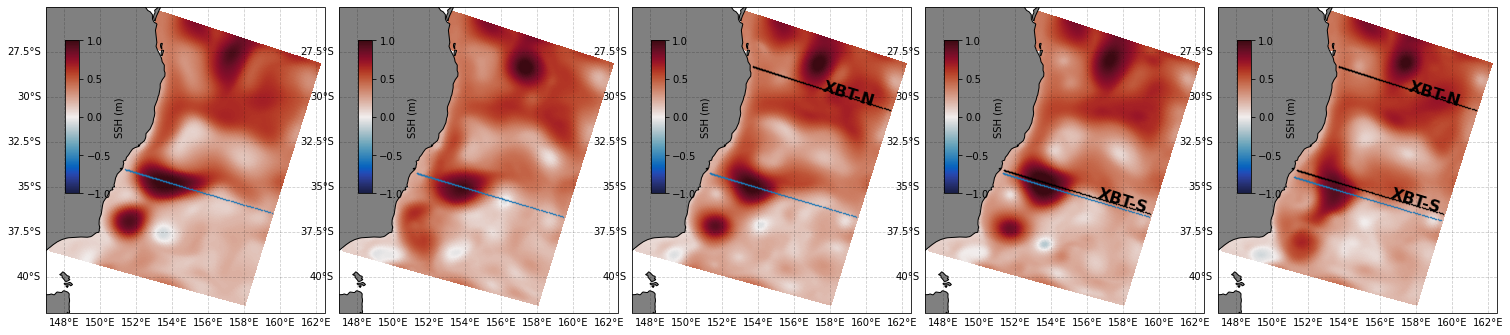

In [22]:
snap = truth



gs = gridspec.GridSpec(nrows=1,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[26,10])
ax = None


toPlotData=truth_eddy3.zeta.mean(dim='ocean_time')
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax = plt.gca()
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, cmap='cmo.balance',vmin=-1,vmax=1)       
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('SSH (m)')
ax.set_title('')  
ax.set(ylabel="Latitude", xlabel="Longitude")
transectEta=120
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="C0",marker='.',markersize=1,zorder=12)



toPlotData=SSHSST_eddy3.zeta.mean(dim='ocean_time')
ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
ax = plt.gca()
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, cmap='cmo.balance',vmin=-1,vmax=1)       
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('SSH (m)')
ax.set_title('')  
ax.set(ylabel="Latitude", xlabel="Longitude")
transectEta=115
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="C0",marker='.',markersize=1,zorder=12)




toPlotData=SSHSST_XBT_N_eddy3.zeta.mean(dim='ocean_time')
ax = fig.add_subplot(gs[0,2], projection=ccrs.PlateCarree())
ax = plt.gca()
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, cmap='cmo.balance',vmin=-1,vmax=1)       
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('SSH (m)')
ax.set_title('')  
ax.set(ylabel="Latitude", xlabel="Longitude")
transectEta=115
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="C0",marker='.',markersize=1,zorder=12)

transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
ax.annotate('XBT-N', xy=(157.5,-30.5),xycoords='data',fontweight='bold',rotation=-17,fontsize=16)


toPlotData=SSHSST_XBT_S_eddy3.zeta.mean(dim='ocean_time')
ax = fig.add_subplot(gs[0,3], projection=ccrs.PlateCarree())
ax = plt.gca()
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, cmap='cmo.balance',vmin=-1,vmax=1)       
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('SSH (m)')
ax.set_title('')  
ax.set(ylabel="Latitude", xlabel="Longitude")
transectEta=115
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="C0",marker='.',markersize=1,zorder=12)


transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
ax.annotate('XBT-S', xy=(156.5,-36.45),xycoords='data',fontweight='bold',rotation=-17,fontsize=16)



toPlotData=SSHSST_XBT_eddy3.zeta.mean(dim='ocean_time')
ax = fig.add_subplot(gs[0,4], projection=ccrs.PlateCarree())
ax = plt.gca()
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, cmap='cmo.balance',vmin=-1,vmax=1)       
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('SSH (m)')
ax.set_title('')  
ax.set(ylabel="Latitude", xlabel="Longitude")
transectEta=110
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="C0",marker='.',markersize=1,zorder=12)


transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
ax.annotate('XBT-N', xy=(157.5,-30.5),xycoords='data',fontweight='bold',rotation=-17,fontsize=16)
ax.annotate('XBT-S', xy=(156.5,-36.45),xycoords='data',fontweight='bold',rotation=-17,fontsize=16)



In [23]:


etaTransect=110
xx_110=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
zz_110=truth.z_rho0.isel(eta_rho=etaTransect).fillna(0).transpose()
zz_110.load(),print('done')
etaTransect=115
xx_115=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
zz_115=truth.z_rho0.isel(eta_rho=etaTransect).fillna(0).transpose()
zz_115.load(),print('done')
etaTransect=120
xx_120=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
zz_120=truth.z_rho0.isel(eta_rho=etaTransect).fillna(0).transpose()
zz_120.load(),print('done')




done
done
done


(<xarray.DataArray 'z_rho0' (s_rho: 30, xi_rho: 272)>
 array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -4.45028145e+03, -4.44502387e+03, -4.44502387e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -4.18001315e+03, -4.17507607e+03, -4.17507607e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -3.68420532e+03, -3.67987708e+03, -3.67987708e+03],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.04693507e+01, -1.04654574e+01, -1.04654577e+01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -5.66414891e+00, -5.66100291e+00, -5.66100317e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.59526814e+00, -1.59262792e+00, -1.59262818e+00]])
 Coordinates:
     z_rho0   (s_rho, xi_rho) float64 0.0 0.0 0.0 0.0 ... -1.595 -1.593 -1.593
   * s_rho    (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
     lo

<Figure size 432x288 with 0 Axes>

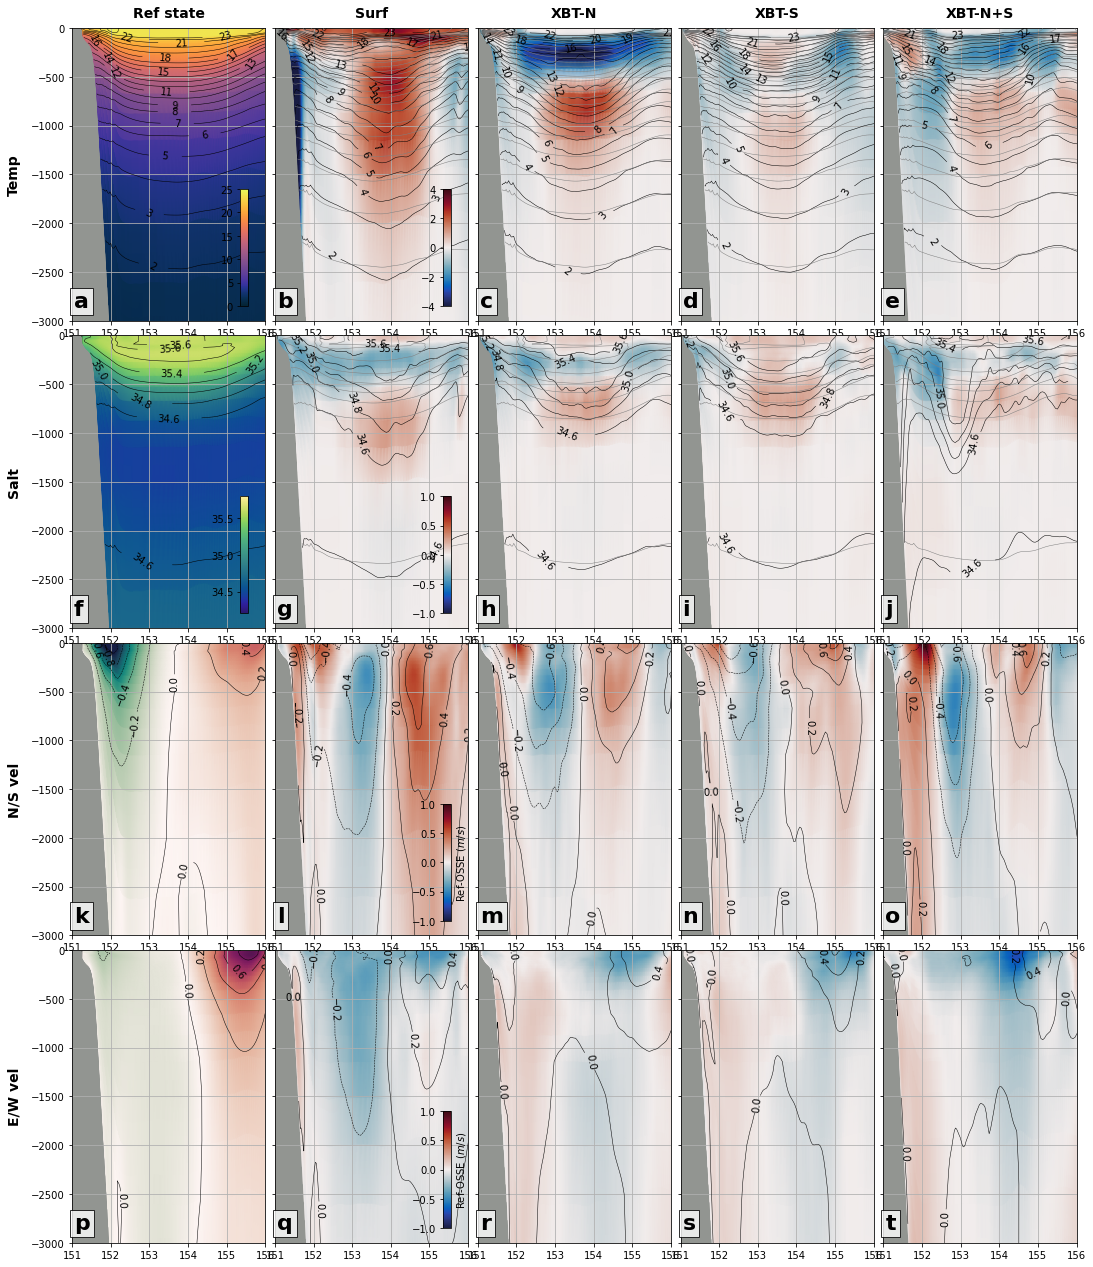

In [30]:

# toPlotData=truth_eddy3.zeta.mean(dim='ocean_time')


# gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
# plt.cla()
# plt.clf()
# fig = plt.figure(figsize=[12.3,8])
# ax = None

# ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
# ax = plt.gca()
# ax.set_extent([147, 162.5, -42, -25])
# feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
# im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, cmap='cmo.balance',vmin=-1,vmax=1)       
# gl = ax.gridlines(draw_labels=True,
#                     color='black', alpha=0.2, linestyle='--')

# gl.right_labels = False
# gl.top_labels = False
# cax = inset_axes(ax,
#                 width="5%",  # width = 10% of parent_bbox width
#                 height="50%",  # height : 50%
#                 loc='lower left',
#                 bbox_to_anchor=(.07,.39, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im, cax=cax) 
# cbar.set_label('SSH (m)')
# ax.set_title('')  
# ax.set(ylabel="Latitude", xlabel="Longitude")
# transectEta=60
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)

# toPlotData=truth_eddy3.temp250.mean(dim='ocean_time')
# ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
# pcol_params={"cmap":"cmo.thermal","vmin":15, "vmax":30, "zorder":1}#, "add_colorbar":"False"}
# cont_params={"colors":"black"}
# ax = plt.gca()
# ax.set_extent([147, 162.5, -42, -25])
# feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
# im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, cmap='cmo.thermal')       
# gl = ax.gridlines(draw_labels=True,
#                     color='black', alpha=0.2, linestyle='--')
# gl.right_labels = False
# gl.top_labels = False
# cax = inset_axes(ax,
#                 width="5%",  # width = 10% of parent_bbox width
#                 height="50%",  # height : 50%
#                 loc='lower left',
#                 bbox_to_anchor=(.07,.39, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im, cax=cax) 
# cbar.set_label('Temperature at 500m ($^\circ$C)')
# ax.set_title('')  
# ax.set(ylabel="Latitude", xlabel="Longitude")
# transectEta=60
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
# ax.annotate('XBT-N', xy=(157.5,-30.5),xycoords='data',fontweight='bold',rotation=-17,fontsize=16)
# ax.annotate('XBT-S', xy=(156.5,-36.45),xycoords='data',fontweight='bold',rotation=-17,fontsize=16)
# plt.show()

def addSubplot_VerticalTransect(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    # cax = inset_axes(ax,
    #              width="5%",  # width = 10% of parent_bbox width
    #              height="50%",  # height : 50%
    #              loc='lower left',
    #              bbox_to_anchor=(.05,.09, .8, .8),
    #              bbox_transform=ax.transAxes,
    #              borderpad=0,
    #              )
    ax.set_ylim([-2000,0])
    # cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.1, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
    ax.grid()
    return ax,im

def addSubplot_VerticalTransect_colorbar(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.87,.05, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    cax.yaxis.tick_left()
    # cax.set_ylabel('vel ($m/s$)')
    ax.set_ylim([-2000,0])
    ax.text(0.01, 0.1, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
    ax.grid()
    return ax,cax,im


gs = gridspec.GridSpec(nrows=5,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[18,28])
ax = None

#60,40,55,47,35

ax = addSubplot_VerticalTransect_colorbar(xx_120,zz_120, truth_eddy3.temp.isel(eta_rho=120).mean(dim='ocean_time') ,gs,0,0,'a',pcol_kwargs={'vmin':0,'vmax':25,'cmap':'cmo.thermal'})#, ax1[0].set_title('u (m/s)')
ax[0].text(-.3, .5, 'Temp',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax[0].transAxes)
co = ax[0].contour(xx_120,zz_120,truth_eddy3.temp.isel(eta_rho=120).mean(dim='ocean_time'),levels=np.arange(0,30,1),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_xlim([151,156])
ax[0].set_ylim([-3000,0])
ax[0].text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)

ax = addSubplot_VerticalTransect_colorbar(xx_115,zz_115, SSHSST_eddy3.temp.isel(eta_rho=115).mean(dim='ocean_time')-truth_eddy3.temp.isel(eta_rho=40).mean(dim='ocean_time') ,gs,0,1,'b',pcol_kwargs={'vmin':-4,'vmax':4,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
# ax = addSubplot_VerticalTransect(xx_60,zz_60, ((( SSHSST_eddy3.v_northward.isel(eta_rho=60)-truth_eddy3.v_northward.isel(eta_rho=60) )**2).mean(dim='ocean_time'))**(1/2) ,gs,0,1,'n',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_115,zz_115,SSHSST_eddy3.temp.isel(eta_rho=115).mean(dim='ocean_time'),levels=np.arange(0,30,1),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
co = ax[0].contour(xx_115,zz_115,truth_eddy3.temp.isel(eta_rho=115).mean(dim='ocean_time'),levels=np.arange(0,30,1),colors='grey',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([151,156])
ax[0].set_ylim([-3000,0])
ax[0].text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)

ax = addSubplot_VerticalTransect(xx_115,zz_115, SSHSST_XBT_N_eddy3.temp.isel(eta_rho=115).mean(dim='ocean_time')-truth_eddy3.temp.isel(eta_rho=115).mean(dim='ocean_time') ,gs,0,2,'c',pcol_kwargs={'vmin':-4,'vmax':4,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_115,zz_115,SSHSST_XBT_N_eddy3.temp.isel(eta_rho=115).mean(dim='ocean_time'),levels=np.arange(0,30,1),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
co = ax[0].contour(xx_115,zz_115,truth_eddy3.temp.isel(eta_rho=115).mean(dim='ocean_time'),levels=np.arange(0,30,1),colors='grey',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([151,156])
ax[0].set_ylim([-3000,0])
ax[0].text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)

ax = addSubplot_VerticalTransect(xx_115,zz_115, SSHSST_XBT_S_eddy3.temp.isel(eta_rho=115).mean(dim='ocean_time')-truth_eddy3.temp.isel(eta_rho=115).mean(dim='ocean_time') ,gs,0,3,'d',pcol_kwargs={'vmin':-4,'vmax':4,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_115,zz_115,SSHSST_XBT_S_eddy3.temp.isel(eta_rho=115).mean(dim='ocean_time'),levels=np.arange(0,30,1),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
co = ax[0].contour(xx_115,zz_115,truth_eddy3.temp.isel(eta_rho=115).mean(dim='ocean_time'),levels=np.arange(0,30,1),colors='grey',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([151,156])
ax[0].set_ylim([-3000,0])
ax[0].text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)

ax = addSubplot_VerticalTransect(xx_110,zz_110, SSHSST_XBT_eddy3.temp.isel(eta_rho=110).mean(dim='ocean_time')-truth_eddy3.temp.isel(eta_rho=110).mean(dim='ocean_time') ,gs,0,4,'e',pcol_kwargs={'vmin':-4,'vmax':4,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_110,zz_110,SSHSST_XBT_eddy3.temp.isel(eta_rho=110).mean(dim='ocean_time'),levels=np.arange(0,30,1),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
co = ax[0].contour(xx_110,zz_110,truth_eddy3.temp.isel(eta_rho=110).mean(dim='ocean_time'),levels=np.arange(0,30,1),colors='grey',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([151,156])
ax[0].set_ylim([-3000,0])
ax[0].text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)

###

#60,40,55,47,35


ax = addSubplot_VerticalTransect_colorbar(xx_120,zz_120, truth_eddy3.salt.isel(eta_rho=120).mean(dim='ocean_time') ,gs,1,0,'f',pcol_kwargs={'vmin':34.2,'vmax':35.8,'cmap':'cmo.haline'})#, ax1[0].set_title('u (m/s)')
ax[0].text(-.3, .5, 'Salt',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax[0].transAxes)
co = ax[0].contour(xx_120,zz_120,truth_eddy3.salt.isel(eta_rho=120).mean(dim='ocean_time'),levels=np.arange(34.2,36,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_xlim([151,156])
ax[0].set_ylim([-3000,0])

ax = addSubplot_VerticalTransect_colorbar(xx_115,zz_115, SSHSST_eddy3.salt.isel(eta_rho=115).mean(dim='ocean_time')-truth_eddy3.salt.isel(eta_rho=115).mean(dim='ocean_time') ,gs,1,1,'g',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
# ax = addSubplot_VerticalTransect(xx_60,zz_60, ((( SSHSST_eddy3.v_northward.isel(eta_rho=60)-truth_eddy3.v_northward.isel(eta_rho=60) )**2).mean(dim='ocean_time'))**(1/2) ,gs,0,1,'n',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_115,zz_115,SSHSST_eddy3.salt.isel(eta_rho=115).mean(dim='ocean_time'),levels=np.arange(34.2,36,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
co = ax[0].contour(xx_115,zz_115,truth_eddy3.salt.isel(eta_rho=115).mean(dim='ocean_time'),levels=np.arange(34.2,36,.2),colors='grey',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([151,156])
ax[0].set_ylim([-3000,0])

ax = addSubplot_VerticalTransect(xx_115,zz_115, SSHSST_XBT_N_eddy3.salt.isel(eta_rho=115).mean(dim='ocean_time')-truth_eddy3.salt.isel(eta_rho=115).mean(dim='ocean_time') ,gs,1,2,'h',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_115,zz_115,SSHSST_XBT_N_eddy3.salt.isel(eta_rho=115).mean(dim='ocean_time'),levels=np.arange(34.2,36,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
co = ax[0].contour(xx_115,zz_115,truth_eddy3.salt.isel(eta_rho=115).mean(dim='ocean_time'),levels=np.arange(34.2,36,.2),colors='grey',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([151,156])
ax[0].set_ylim([-3000,0])

ax = addSubplot_VerticalTransect(xx_115,zz_115, SSHSST_XBT_S_eddy3.salt.isel(eta_rho=115).mean(dim='ocean_time')-truth_eddy3.salt.isel(eta_rho=115).mean(dim='ocean_time') ,gs,1,3,'i',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_115,zz_115,SSHSST_XBT_S_eddy3.salt.isel(eta_rho=115).mean(dim='ocean_time'),levels=np.arange(34.2,36,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
co = ax[0].contour(xx_115,zz_115,truth_eddy3.salt.isel(eta_rho=115).mean(dim='ocean_time'),levels=np.arange(34.2,36,.2),colors='grey',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([151,156])
ax[0].set_ylim([-3000,0])

ax = addSubplot_VerticalTransect(xx_110,zz_110, SSHSST_XBT_eddy3.salt.isel(eta_rho=110).mean(dim='ocean_time')-truth_eddy3.salt.isel(eta_rho=110).mean(dim='ocean_time') ,gs,1,4,'j',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_110,zz_110,SSHSST_XBT_eddy3.salt.isel(eta_rho=35).mean(dim='ocean_time'),levels=np.arange(34.2,36,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
co = ax[0].contour(xx_110,zz_110,truth_eddy3.salt.isel(eta_rho=110).mean(dim='ocean_time'),levels=np.arange(34.2,36,.2),colors='grey',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([151,156])
ax[0].set_ylim([-3000,0])

###

#60,40,55,47,35


ax = addSubplot_VerticalTransect(xx_120,zz_120, truth_eddy3.v_northward.isel(eta_rho=120).mean(dim='ocean_time') ,gs,2,0,'k',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.curl'})#, ax1[0].set_title('u (m/s)')
ax[0].text(-.3, .5, 'N/S vel',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax[0].transAxes)
co = ax[0].contour(xx_120,zz_120,truth_eddy3.v_northward.isel(eta_rho=120).mean(dim='ocean_time'),levels=np.arange(-1,1.2,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_xlim([151,156])
ax[0].set_ylim([-3000,0])

ax = addSubplot_VerticalTransect_colorbar(xx_115,zz_115, (SSHSST_eddy3.v_northward.isel(eta_rho=115).mean(dim='ocean_time')-truth_eddy3.v_northward.isel(eta_rho=115).mean(dim='ocean_time')) ,gs,2,1,'l',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
# ax = addSubplot_VerticalTransect(xx_60,zz_60, ((( SSHSST_eddy3.v_northward.isel(eta_rho=60)-truth_eddy3.v_northward.isel(eta_rho=60) )**2).mean(dim='ocean_time'))**(1/2) ,gs,0,1,'n',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_115,zz_115,SSHSST_eddy3.v_northward.isel(eta_rho=115).mean(dim='ocean_time'),levels=np.arange(-1,1.2,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_yticklabels([])
ax[0].set_xlim([151,156])
ax[0].set_ylim([-3000,0])
ax[1].set_ylabel('Ref-OSSE ($m/s$)')

ax = addSubplot_VerticalTransect(xx_115,zz_115, (SSHSST_XBT_N_eddy3.v_northward.isel(eta_rho=115).mean(dim='ocean_time')-truth_eddy3.v_northward.isel(eta_rho=115).mean(dim='ocean_time')) ,gs,2,2,'m',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_115,zz_115,SSHSST_XBT_N_eddy3.v_northward.isel(eta_rho=115).mean(dim='ocean_time'),levels=np.arange(-1,1.2,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_yticklabels([])
ax[0].set_xlim([151,156])
ax[0].set_ylim([-3000,0])

ax = addSubplot_VerticalTransect(xx_115,zz_115, (SSHSST_XBT_S_eddy3.v_northward.isel(eta_rho=115).mean(dim='ocean_time')-truth_eddy3.v_northward.isel(eta_rho=115).mean(dim='ocean_time')) ,gs,2,3,'n',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_115,zz_115,SSHSST_XBT_S_eddy3.v_northward.isel(eta_rho=115).mean(dim='ocean_time'),levels=np.arange(-1,1.2,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_yticklabels([])
ax[0].set_xlim([151,156])
ax[0].set_ylim([-3000,0])


ax = addSubplot_VerticalTransect(xx_110,zz_110, (SSHSST_XBT_eddy3.v_northward.isel(eta_rho=110).mean(dim='ocean_time')-truth_eddy3.v_northward.isel(eta_rho=110).mean(dim='ocean_time')) ,gs,2,4,'o',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_110,zz_110,SSHSST_XBT_eddy3.v_northward.isel(eta_rho=110).mean(dim='ocean_time'),levels=np.arange(-1,1.2,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_yticklabels([])
ax[0].set_xlim([151,156])
ax[0].set_ylim([-3000,0])

###

#60,40,55,47,35


ax = addSubplot_VerticalTransect(xx_120,zz_120, truth_eddy3.u_eastward.isel(eta_rho=120).mean(dim='ocean_time') ,gs,3,0,'p',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.curl'})#, ax1[0].set_title('u (m/s)')
ax[0].text(-.3, .5, 'E/W vel',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax[0].transAxes)
co = ax[0].contour(xx_120,zz_120,truth_eddy3.u_eastward.isel(eta_rho=120).mean(dim='ocean_time'),levels=np.arange(-1,1.2,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_xlim([151,156])
ax[0].set_ylim([-3000,0])

ax = addSubplot_VerticalTransect_colorbar(xx_115,zz_115, (SSHSST_eddy3.u_eastward.isel(eta_rho=115).mean(dim='ocean_time')-truth_eddy3.u_eastward.isel(eta_rho=115).mean(dim='ocean_time')) ,gs,3,1,'q',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
# ax = addSubplot_VerticalTransect(xx_60,zz_60, ((( SSHSST_eddy3.v_northward.isel(eta_rho=60)-truth_eddy3.v_northward.isel(eta_rho=60) )**2).mean(dim='ocean_time'))**(1/2) ,gs,0,1,'n',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_115,zz_115,SSHSST_eddy3.u_eastward.isel(eta_rho=115).mean(dim='ocean_time'),levels=np.arange(-1,1.2,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_yticklabels([])
ax[0].set_xlim([151,156])
ax[0].set_ylim([-3000,0])
ax[1].set_ylabel('Ref-OSSE ($m/s$)')

ax = addSubplot_VerticalTransect(xx_115,zz_115, (SSHSST_XBT_N_eddy3.u_eastward.isel(eta_rho=115).mean(dim='ocean_time')-truth_eddy3.u_eastward.isel(eta_rho=115).mean(dim='ocean_time')) ,gs,3,2,'r',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_115,zz_115,SSHSST_XBT_N_eddy3.u_eastward.isel(eta_rho=115).mean(dim='ocean_time'),levels=np.arange(-1,1.2,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_yticklabels([])
ax[0].set_xlim([151,156])
ax[0].set_ylim([-3000,0])

ax = addSubplot_VerticalTransect(xx_115,zz_115, (SSHSST_XBT_S_eddy3.u_eastward.isel(eta_rho=115).mean(dim='ocean_time')-truth_eddy3.u_eastward.isel(eta_rho=115).mean(dim='ocean_time')) ,gs,3,3,'s',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_115,zz_115,SSHSST_XBT_S_eddy3.u_eastward.isel(eta_rho=115).mean(dim='ocean_time'),levels=np.arange(-1,1.2,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_yticklabels([])
ax[0].set_xlim([151,156])
ax[0].set_ylim([-3000,0])


ax = addSubplot_VerticalTransect(xx_110,zz_110, (SSHSST_XBT_eddy3.u_eastward.isel(eta_rho=110).mean(dim='ocean_time')-truth_eddy3.u_eastward.isel(eta_rho=110).mean(dim='ocean_time')) ,gs,3,4,'t',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.balance'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_110,zz_110,SSHSST_XBT_eddy3.u_eastward.isel(eta_rho=110).mean(dim='ocean_time'),levels=np.arange(-1,1.2,.2),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_yticklabels([])
ax[0].set_xlim([151,156])
ax[0].set_ylim([-3000,0])

plt.show()